# Investigation of Effects of WDM on 2PCF in different regimes

In this notebook, we set out to check out the effects of WDM on three different regimes of the correlation function: the totally 1-halo part, the intermediate part, and the 2-halo part. We want to check if everything makes sense, and detect any features that may permit fitting the WDM mass.

In [44]:
%pylab inline
from halomod.wdm import HaloModelWDM
from copy import deepcopy

Populating the interactive namespace from numpy and matplotlib


## Setup

We basically use what we would consider to be the best components available currently: a mass function defined by Schneider+13 using the Sharp-$k$ formalism (updated to Schneider+14 parameters), NFW profile with Duffy et. a. CM relation (modified to WDM), and a bias model from Tinker+10.

Additionally, we improve the halo exclusion model compared to Schneider, using instead the Ng-Matched approach of Tinker+05. Finally, we use a very simple HOD parameterisation with 3 parameters, and this is just because we want to keep things simple on this side of things.

In [45]:
kwargs = dict(scale_dependent_bias="Tinker_SD05",takahashi=True,mf_fit="SMT",z=0,fsig_params={"a":1},
                filter="SharpK",filter_params={"c":2.5},cm_relation="DuffyWDM",hod_model="Zehavi05",
                hod_params={"alpha":1.214,"M_1":13.396,"M_min":12.0478},halo_exclusion="NgMatched_",
                _hc_spectrum="nonlinear",wdm_mass=0.1)

wdm = HaloModelWDM(**kwargs)

As our "CDM" model, we use a WDM model with very high particle mass. This should alleviate any small numerical differences just by using the transfer function.

In [46]:
cdm = deepcopy(wdm)
cdm.update(wdm_mass=10000.0)


## Small-Scale

In [47]:
from halomod import ProjectedCF

class ProjectedCFWDM(ProjectedCF,HaloModelWDM):
    pass

wdm = ProjectedCFWDM(**kwargs)
cdm = deepcopy(wdm)
cdm.update(wdm_mass=10000.0)

wdm.rlog=True
cdm.rlog=True
wdm.update(rp_min=0.01,rp_max=2.,rp_num=40,rnum=80)
cdm.update(rp_min=0.01,rp_max=2.,rp_num=40,rnum=80)


In the 1-halo term, there are two components which are directly affected by the WDM model: $n(m)$ and $\rho(r|m)$ or $\lambda(r|m)$ via $\bar{c}(m)$. For reasons that we outline below, while both of these will contribute to a potential WDM signautre, we expect the dominant contribution to be through the halo profile.

In particular, the truncation of the mass function due to WDM particle mass should be mimicked by the HOD parameter $M_{min}$, which controls truncation of the integral via the galaxy abundance. Therefore, we should not expect that the WDM HMF will solely contribute to a detection of WDM in this context, since it will be degenerate with the HOD. This is not the case for the halo profile, however.

On average we expect WDM haloes to exhibit lower concentrations than their CDM counterparts, with the largest discrepancy at small halo masses. If the integrals extend to low enough mass scales, this discrepancy will begin to be non-negligible (in general we might expect that `low enough' refers to scales $\approx m_{\rm hm}$). 

Note that since the turnover for $\bar{c}(m)$ is an order of magnitude above $m_{\rm hm}$, while the turnover in the HMF is slightly below $m_{\rm hm}$, there is still sufficient number density of haloes present at low mass to reduce the "effective concentration":

$$	c_{\rm eff} = \frac{1}{n_g} \int_{M_{\rm min}} n(m) N_t(m) c(m) dm $$


In [48]:
from scipy.integrate import simps
def c_eff(h):
    integ = h.dndm*h.n_tot*h.concentration
    return simps(integ,h.M)/h.mean_gal_den.value

In [134]:
c_eff(cdm)

6.4350277186768547

Here, let's make a plot of $c_{\rm eff}$ as a function of $M_{\rm min}$, for a CDM cosmology, and the three usual WDM cosmologies:

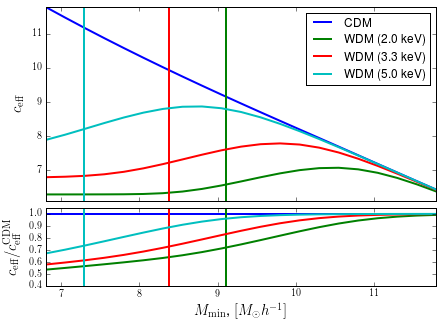

In [51]:
mmins = np.arange(6.8,12,0.25)
ceff_cdm = np.zeros_like(mmins)
ceff_wdm = np.zeros((len(mmins),3))
mhm = []
for i,mmin in enumerate(mmins):
    cdm.update(hod_params={"M_min":mmin,"M_1":mmin+1.2,"alpha":1.0})
    wdm.update(hod_params={"M_min":mmin,"M_1":mmin+1.2,"alpha":1.0})
    ceff_cdm[i] = c_eff(cdm)
    for j,mx in enumerate([2.0,3.3,7.0]):
        wdm.update(wdm_mass=mx)
        ceff_wdm[i,j] = c_eff(wdm)
        mhm.append(log10(wdm._wdm.m_hm.value))
        
fig,ax = subplots(2,1,sharex=True,
                 gridspec_kw={"height_ratios":[2.5,1],"hspace":0.05},figsize=(7,5))
        
ax[0].plot(mmins,ceff_cdm,lw=2,color="b",label="CDM")
ax[1].plot(mmins,np.ones_like(mmins),lw=2,color="b")

cols = ['g','r','c']
for j,mx in enumerate([2.0,3.3,5.0]):
    ax[0].plot(mmins,ceff_wdm[:,j],label="WDM (%s keV)"%mx,lw=2,color=cols[j])
    ax[1].plot(mmins,ceff_wdm[:,j]/ceff_cdm,lw=2,color=cols[j])
    ax[0].axvline(mhm[j],lw=2,color=cols[j])
    ax[1].axvline(mhm[j],lw=2,color=cols[j])
    
ax[0].legend(loc=0)
ax[1].set_xlabel(r"$M_{\rm min}$, $[M_\odot h^{-1}]$",fontsize=15)
ax[0].set_ylabel(r"$c_{\rm eff}$",fontsize=15)
ax[1].set_ylabel(r"$c_{\rm eff}/c_{\rm eff}^{\rm CDM}$",fontsize=15)
ax[1].set_ylim((0.4,1.05))
ax[0].set_ylim((6.1,11.8))
ax[1].set_xlim((6.8,11.8))
savefig("thorough_inv_figs/concentration_effective.pdf")

So the effective concentration of galaxies in the sample turns over much like the concentration-mass relation, with decreasing $M_{\rm min}$.

Let's have a look at the dependence of the density on $m$, for a few different scales. In the figure below, we plot the density $\rho(r|m)$ over all $m>M_{\rm min}$, for 4 values of $r$, which represent four different regimes. In each case, we normalise $\rho(r|m)$ to unity at $m = 10^{18} M_\odot h^{-1}$. The high-mass slope of each curve is identical, and in reality the curves are displaced from their visual position, with smaller $r$ having higher density. 

Additionally shown as thick lines, as a visual guide, is the rest of the integrand: $n(m) N_s(m) N_t(m) m $, where the multiplication by $m$ is to aid interpretation, since we plot in log space. Ignoring the constant factor of the mean galaxy density in each case, the total integral can be interpreted as the sum of $\rho(r|m_i)$ weighted by the thick lines. The value of this weighted sum in each case is shown by horizontal dashed lines.

Importantly, the heighest weight (if valid for a given $r$) is given to $m \sim M_\star$. The relative strength of this weight will be given by the HOD slope $\alpha$ combined with the power-law slope of $n(m)$. In principle, the slope of $n(m)$ cannot be lower than -2, so $\alpha \ge 1$ will always have this effect to some degree. Furthermore, the location of $M_\star$ is cosmology-dependent. 


0.560567653775
0.899011785213
1.00715655282
1.00040886846


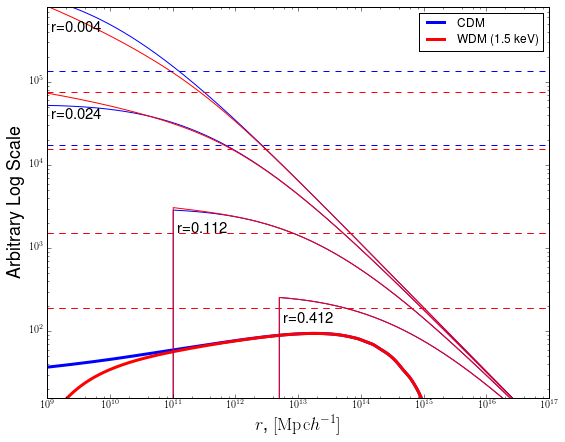

In [11]:
cdm.update(wdm_mass=100000.0,hod_params={"M_min":9.0,"M_1":10.2,"alpha":1.0})
wdm.update(wdm_mass=1.5,hod_params={"M_min":9.0,"M_1":10.2,"alpha":1.0})

plt.figure(figsize=(9,7))

cdm_ninteg = cdm.dndm*cdm.n_sat*cdm.n_cen * cdm.M
wdm_ninteg = wdm.dndm*wdm.n_sat*wdm.n_cen * wdm.M

plot(cdm.M,cdm_ninteg*320,label="CDM",lw=3,color="b")
plot(cdm.M,wdm_ninteg*320,label="WDM (1.5 keV)",lw=3,color="r")

for i,mvir in enumerate([5e6,1e9,1e11,5e12]):
    rvir = cdm.profile._mvir_to_rvir(mvir*cdm.M.unit)
    cdm_rinteg = cdm.profile.rho(rvir,cdm.M,norm="m")
    wdm_rinteg = wdm.profile.rho(rvir,cdm.M,norm="m")
    
    # Normalise
    cdm_rinteg /= cdm_rinteg[-1]
    wdm_rinteg /= wdm_rinteg[-1]
    
    plot(cdm.M,cdm_rinteg,color="b")
    plot(cdm.M,wdm_rinteg,color="r")
    annotate("r=%.3f"%rvir.value,xy=(1e10,100),xytext=(max(mvir,1e9)*1.2,wdm_rinteg.value.max()/2),fontsize=15)

    mask = cdm_rinteg>0
    avg_cdm = average(cdm_rinteg[mask],weights=cdm_ninteg[mask]/sum(cdm_ninteg[mask]))
    #print cdm_ninteg[mask]/sum(cdm_ninteg[mask])
    avg_wdm = average(wdm_rinteg[mask],weights=wdm_ninteg[mask]/sum(wdm_ninteg[mask]))
    axhline(avg_cdm,ls="--",color="b")
    axhline(avg_wdm,ls="--",color="r")
    print avg_wdm/avg_cdm
    #annotate("r=%.3f"%rvir.value,xy=(2e9,6e2),xytext=(1e16,3e-2),fontsize=15)


xscale('log')
yscale('log')
xlim((1e9,1e17))
ylim((16,8e5))
legend(loc=0)
xlabel(r"$r$, $[{\rm Mpc}h^{-1}]$",fontsize=18)
ylabel("Arbitrary Log Scale",fontsize=18)

savefig("thorough_inv_figs/rho_m.pdf")

The primary observation is that at any distance scale $r$, the range of valid $m$ is set by $m_{\rm vir}(r)$. The interplay of this scale with $m_{\rm hm}$, $M_{\rm min}$ and $M_\star$ introduces four regimes of interest. We consider each of these regimes in turn.

At large scales (the exact scales depend on $m_x$), the entire range of valid $m$ is so large that the concentration difference between WDM and CDM is negligible, and we do not detect any difference in the final correlation (modulo the multiplicative factor of the mean galaxy density). 

As the scale decreases, the concentration difference increases, but this is largely mitigated by three effects: firstly, the heighest weights are still fixed at $M_\star$; secondly, the relative strength of the $M_\star$ weight is increased by the turnover in $n(m)$; and thirdly, at smaller scales, $M_\star$ will become sufficiently larger than the virial mass, to reverse the effect of the difference in concentration. At these scales, a lower concentration *reduces* the density and thus the correlation. Depending on the precise parameters, we may still expect a small increase in the correlations of WDM compared to CDM at this scale, but they will be negligible compared to the differences at still smaller scales. 

As the scale decreases further (eg. the $r=0.024$ curve in the above figure, which corresponds to a virial mass of exactly $M_{\rm min}$), though the suppressed concentration of WDM has a larger effect on the density (especially at the virial radius), the corresponding turnover in the HMF reverses the expected effects (due to the above reasons) and we have an overall decrease in the correlation. 

Beyond this scale, the integral becomes "saturated", ie. the range of valid masses extends below $M_{\rm min}$, which becomes the truncation mass. In effect, since all valid masses are above the virial mass, all three of the mitigating effects are in full swing and we expect a decrease in the correlation function in the WDM case. The asymptotic limit of this decrease is reached as the inner logarithmic slope of the NFW profile reaches its asymptotic limit of -1. At this point, the behaviour of both WDM and CDM is identical, though the WDM will have a consistently lower density/correlation, set by the concentration difference at $M_{\rm min}$.

The following plot clearly shows each of these regimes:

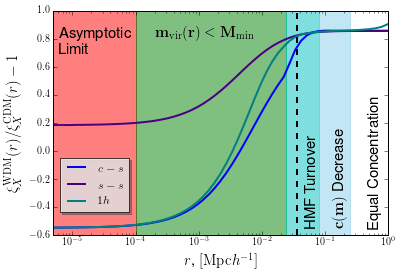

In [12]:
cdm.update(hod_params={"M_min":9.0},rp_min=0.000005)
wdm.update(hod_params={"M_min":9.0},rp_min=0.000005)

mask = cdm.r.value<1.0
norm_cdm = cdm.corr_gg_1h_cs[mask]
norm_wdm = wdm.corr_gg_1h_cs[mask]

ratio = norm_wdm/norm_cdm
#ratio /= max(ratio)/1.05

plot(cdm.r[mask],ratio-1,lw=2,label=r"$c-s$")
plot(cdm.r[mask],wdm.corr_gg_1h_ss[mask]/cdm.corr_gg_1h_ss[mask]-1,lw=2,color="indigo",label=r"$s-s$")
plot(cdm.r[mask],wdm.corr_gg_1h[mask]/cdm.corr_gg_1h[mask]-1,lw=2,color="teal",label=r"$1h$")

xscale('log')
#yscale('symlog',linthreshy=0.0015)
xlim((5e-6,1))
#yscale('log')

axvspan(5e-6,1e-4,alpha=0.5,color="r")
axvspan(1e-4,cdm.profile._mvir_to_rvir(cdm.M[0]).value,alpha=0.5,color="g")
axvspan(cdm.profile._mvir_to_rvir(cdm.M[0]).value,8e-2,alpha=0.5,color="c")
axvspan(8e-2,2.5e-1,alpha=0.5,color="skyblue")

annotate("Asymptotic\n Limit",xy=(1e-3,0.4),xytext=(6.2e-6,0.7),fontsize=15)
annotate(r"$\mathbf{m_{\rm vir}(r) < M_{\rm min}}$",xy=(1e-3,0.4),xytext=(2e-4,0.8),fontsize=15)
annotate("HMF Turnover",xy=(1e-3,0.4),xytext=(4.6e-2,0.04),rotation="vertical",fontsize=15)
annotate(r"$\mathbf{c(m)}$ Decrease",xy=(1e-3,0.4),xytext=(1.3e-1,0.087),rotation="vertical",fontsize=15)

annotate("Equal Concentration",xy=(1e-3,0.4),xytext=(4.6e-1,0.33),rotation="vertical",fontsize=15)

axvline(wdm.profile._mvir_to_rvir(wdm._wdm.m_hm).value,lw=2,color="k",ls="--")

xlabel(r"$r$, $[{\rm Mpc}h^{-1}]$",fontsize=15)
ylabel(r"$\xi_X^{\rm WDM}(r)/\xi_X^{\rm CDM}(r)-1$",fontsize=15)

legend(loc=(0.02,0.1),shadow=True,framealpha=0.7)
#axvline(cdm.profile._mvir_to_rvir(cdm.M[0]).value)

savefig("thorough_inv_figs/regions.pdf")

Each shaded region shows a different regime, as described. The general shape of the ratio is an "S"-curve, with flat behaviour at both scale extremes. The value of the upper plateau is set by the ratio $(n_g^{\rm CDM}/n_g^{\rm WDM})^2$, whereas the value of the lower plateau is affected both by this ratio and the effective concentration. 

The middle parts of the curve can be seen as a somewhat smooth interpolation between these plateaus. However, there are two small inconsistencies: firstly there is a discontinuity in the first derivative at $r=r_{\rm vir}(M_{\rm min}$, and secondly the lower parts of the "Equal Concentration" region have an imperceivable upturn due to the effects of the reduced concentration at the virial radius on scales in between the dominance of the HMF turnover and equal concentrations.

We would further like to know the interplay between the WDM effects and the HOD parameters. The most important of these is $M_{\rm min}$, which has a somewhat complicated effect in detail. On the large-scale plateau, increasing $M_{\rm min}$ will serve to reduce the difference between the CDM and WDM galaxy densities, by truncating the integral above the HMF turnover, and thus reducing the amplitude of the plateau. On the smallest scales, this effect will also be involved, but the additional effect of a more similar effective concentration also serves to reduce the disparity between models. Clearly, it will also move the position of the discontinuity. Interestingly, it should not affect any chance of an upturn, unless it is entirely above the relevant scale. In short, a lower intrinsice $M_{\rm min}$ is beneficial for delineating the dark matter models. 

The parameter $M_1$ merely becomes a multiplicative factor in the integral for both CDM and WDM, and therefore its effect here is completely cancelled. Alternately, it also affects the mean galaxy densities in a non-trivial manner. This will result in an overall multiplication of the correlation ratio, with smaller values of $M_1$ leading to smaller multiplicative factors.

The parameter $\alpha$ has an interesting effect. It's most obvious effect is precisely the same as $M_1$, through the factor $M_1^\alpha$. However, it also changes the slope of the 'weights' in the above figure. For $\alpha>1$, the weights take the qualitative form that appears in that figure -- a rise to $M_\star$, then a sharp cutoff. The steepness of this rise, and therefore the strength of the relative weight of $M_\star$ scales, depends on the magnitude of $\alpha$. Thus we expect high $\alpha$ to erase differences between WDM and CDM so long as $M_\star\gg m_{\rm hm}$. On the contrary, decreasing $\alpha$ below unity can lead to the situation that the heighest-weighted mass scale is the lowest valid scale for a given $r$. This enhances the effects of the "upturn", where increase in $\rho$ outweighs the effects of the HMF turnover. 

For illustrative purposes, we plot an example of each of these cases in the figure below.

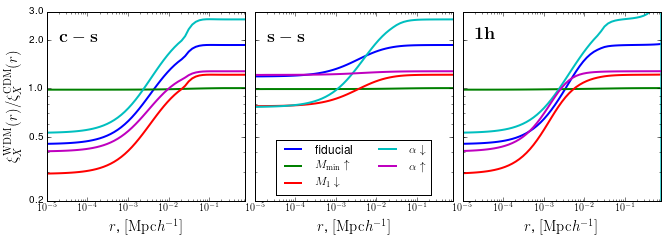

In [13]:
yticks = [0.2,0.5,1.0,2.0,3.0]
ytlabs = [str(y) for y in yticks]

fig,ax = subplots(1,3,sharex=True,sharey=True,gridspec_kw={"wspace":0.05,"bottom":0.15},figsize=(11,3.5),
                  subplot_kw={"xscale":'log','yscale':'log',"xlim":(1e-5,0.75),
                              "ylim":(2e-1,3),"yticks":yticks,"yticklabels":ytlabs})

cdm.update(hod_params={"M_min":9.0,"M_1":10.2,"alpha":1.0},rp_min=0.00001)
wdm.update(hod_params={"M_min":9.0,"M_1":10.2,"alpha":1.0},rp_min=0.00001)
ax[0].plot(cdm.r,wdm.corr_gg_1h_cs/cdm.corr_gg_1h_cs,label="fiducial",lw=2)
ax[1].plot(cdm.r,wdm.corr_gg_1h_ss/cdm.corr_gg_1h_ss,label="fiducial",lw=2)
ax[2].plot(cdm.r,wdm.corr_gg_1h/cdm.corr_gg_1h,label="fiducial",lw=2)

cdm.update(hod_params={"M_min":12.0})
wdm.update(hod_params={"M_min":12.0})
ax[0].plot(cdm.r,wdm.corr_gg_1h_cs/cdm.corr_gg_1h_cs,label=r"$M_{\rm min} \uparrow$",lw=2)
ax[1].plot(cdm.r,wdm.corr_gg_1h_ss/cdm.corr_gg_1h_ss,label=r"$M_{\rm min} \uparrow$",lw=2)
ax[2].plot(cdm.r,wdm.corr_gg_1h/cdm.corr_gg_1h,label=r"$M_{\rm min} \uparrow$",lw=2)


cdm.update(hod_params={"M_min":9.0,"M_1":9.0})
wdm.update(hod_params={"M_min":9.0,"M_1":9.0})
ax[0].plot(cdm.r,wdm.corr_gg_1h_cs/cdm.corr_gg_1h_cs,label=r"$M_1 \downarrow$",lw=2)
ax[1].plot(cdm.r,wdm.corr_gg_1h_ss/cdm.corr_gg_1h_ss,label=r"$M_1 \downarrow$",lw=2)
ax[2].plot(cdm.r,wdm.corr_gg_1h/cdm.corr_gg_1h,label=r"$M_1 \downarrow$",lw=2)

cdm.update(hod_params={"M_1":10.2,"alpha":0.8})
wdm.update(hod_params={"M_1":10.2,"alpha":0.8})
ax[0].plot(cdm.r,wdm.corr_gg_1h_cs/cdm.corr_gg_1h_cs,label=r"$\alpha \downarrow$",lw=2)
ax[1].plot(cdm.r,wdm.corr_gg_1h_ss/cdm.corr_gg_1h_ss,label=r"$\alpha \downarrow$",lw=2)
ax[2].plot(cdm.r,wdm.corr_gg_1h/cdm.corr_gg_1h,label=r"$\alpha \downarrow$",lw=2)

cdm.update(hod_params={"M_1":10.2,"alpha":1.2})
wdm.update(hod_params={"M_1":10.2,"alpha":1.2})
ax[0].plot(cdm.r,wdm.corr_gg_1h_cs/cdm.corr_gg_1h_cs,label=r"$\alpha \uparrow$",lw=2)
ax[1].plot(cdm.r,wdm.corr_gg_1h_ss/cdm.corr_gg_1h_ss,label=r"$\alpha \uparrow$",lw=2)
ax[2].plot(cdm.r,wdm.corr_gg_1h/cdm.corr_gg_1h,label=r"$\alpha \uparrow$",lw=2)

ax[1].legend(loc="lower center",ncol=2)
for i in range(3):
    ax[i].set_xlabel(r"$r$, $[{\rm Mpc}h^{-1}]$",fontsize=15)
ax[0].set_ylabel(r"$\xi_X^{\rm WDM}(r)/\xi_X^{\rm CDM}(r)$",fontsize=15)
#ax[1].set_ylabel(r"$\xi_{s-s}^{\rm WDM}(r)/\xi_{s-s}^{\rm CDM}(r)$",fontsize=15)
#ax[2].set_ylabel(r"$\xi_{1h}^{\rm WDM}(r)/\xi_{1h}^{\rm CDM}(r)$",fontsize=15)

ax[0].annotate(r"$\mathbf{c-s}$",xy=(1e-3,1),xytext=(2e-5,2.0),fontsize=18)
ax[1].annotate(r"$\mathbf{s-s}$",xy=(1e-3,1),xytext=(2e-5,2.0),fontsize=18)
ax[2].annotate(r"$\mathbf{1h}$",xy=(1e-3,1),xytext=(2e-5,2.0),fontsize=18)
savefig("thorough_inv_figs/wdm_hod_interplay.pdf")


The problem with this plot is that the mean densities aren't the same. Let's try it with that specified:

{'alpha': 1.0, 'M_min': 9.4164265948097299, 'M_1': 10.2}
{'alpha': 1.0, 'M_min': 10.561755631102747, 'M_1': 10.2}
{'alpha': 1.0, 'M_min': 9.377068241158323, 'M_1': 11.0}
{'alpha': 0.8, 'M_min': 9.4106531242330824, 'M_1': 10.2}
{'alpha': 1.2, 'M_min': 9.4255619916294719, 'M_1': 10.2}


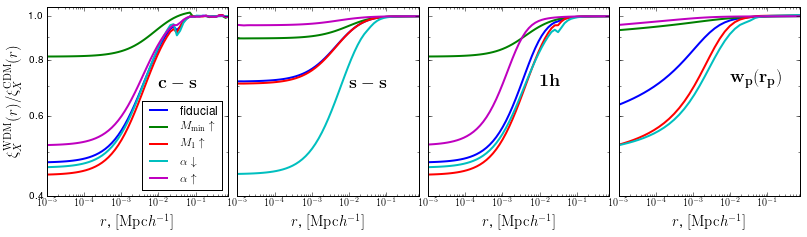

In [18]:
yticks = [0.4,0.6,0.8,1.0]
ytlabs = [str(y) for y in yticks]

fig,ax = subplots(1,4,sharex=True,sharey=True,gridspec_kw={"wspace":0.05,"bottom":0.15},figsize=(13.5,3.5),
                  subplot_kw={"xscale":'log','yscale':'log',"xlim":(1e-5,0.75),
                              "ylim":(0.4,1.05),"yticks":yticks,"yticklabels":ytlabs})

wdm.update(hod_params={"M_min":9.0,"M_1":10.2,"alpha":1.0},rp_min=0.00001)
cdm.update(ng=wdm.mean_gal_den.value,hod_params={"M_1":10.2,"alpha":1.0},rp_min=0.00001)
print cdm.hod_params

ax[0].plot(cdm.r,wdm.corr_gg_1h_cs/cdm.corr_gg_1h_cs,label="fiducial",lw=2)
ax[1].plot(cdm.r,wdm.corr_gg_1h_ss/cdm.corr_gg_1h_ss,label="fiducial",lw=2)
ax[2].plot(cdm.r,wdm.corr_gg_1h/cdm.corr_gg_1h,label="fiducial",lw=2)
ax[3].plot(cdm.rp,wdm.projected_corr_gal/cdm.projected_corr_gal,label="fiducial",lw=2)

wdm.update(hod_params={"M_min":10.5})
cdm.update(ng=wdm.mean_gal_den.value,rp_min=0.00001)
print cdm.hod_params
ax[0].plot(cdm.r,wdm.corr_gg_1h_cs/cdm.corr_gg_1h_cs,label=r"$M_{\rm min} \uparrow$",lw=2)
ax[1].plot(cdm.r,wdm.corr_gg_1h_ss/cdm.corr_gg_1h_ss,label=r"$M_{\rm min} \uparrow$",lw=2)
ax[2].plot(cdm.r,wdm.corr_gg_1h/cdm.corr_gg_1h,label=r"$M_{\rm min} \uparrow$",lw=2)
ax[3].plot(cdm.rp,wdm.projected_corr_gal/cdm.projected_corr_gal,label=r"$M_{\rm min} \uparrow$",lw=2)

wdm.update(hod_params={"M_min":9.0,"M_1":11.0})
cdm.update(ng=wdm.mean_gal_den.value,hod_params={"M_1":11.0},rp_min=0.00001)
print cdm.hod_params
ax[0].plot(cdm.r,wdm.corr_gg_1h_cs/cdm.corr_gg_1h_cs,label=r"$M_1 \uparrow$",lw=2)
ax[1].plot(cdm.r,wdm.corr_gg_1h_ss/cdm.corr_gg_1h_ss,label=r"$M_1 \uparrow$",lw=2)
ax[2].plot(cdm.r,wdm.corr_gg_1h/cdm.corr_gg_1h,label=r"$M_1 \uparrow$",lw=2)
ax[3].plot(cdm.rp,wdm.projected_corr_gal/cdm.projected_corr_gal,label=r"$M_1 \uparrow$",lw=2)

wdm.update(hod_params={"M_1":10.2,"alpha":0.8})
cdm.update(ng=wdm.mean_gal_den.value,hod_params={"M_1":10.2,"alpha":0.8},rp_min=0.00001)
print cdm.hod_params
ax[0].plot(cdm.r,wdm.corr_gg_1h_cs/cdm.corr_gg_1h_cs,label=r"$\alpha \downarrow$",lw=2)
ax[1].plot(cdm.r,wdm.corr_gg_1h_ss/cdm.corr_gg_1h_ss,label=r"$\alpha \downarrow$",lw=2)
ax[2].plot(cdm.r,wdm.corr_gg_1h/cdm.corr_gg_1h,label=r"$\alpha \downarrow$",lw=2)
ax[3].plot(cdm.rp,wdm.projected_corr_gal/cdm.projected_corr_gal,label=r"$\alpha \downarrow$",lw=2)

wdm.update(hod_params={"M_1":10.2,"alpha":1.2})
cdm.update(ng=wdm.mean_gal_den.value,hod_params={"M_1":10.2,"alpha":1.2},rp_min=0.00001)
print cdm.hod_params
ax[0].plot(cdm.r,wdm.corr_gg_1h_cs/cdm.corr_gg_1h_cs,label=r"$\alpha \uparrow$",lw=2)
ax[1].plot(cdm.r,wdm.corr_gg_1h_ss/cdm.corr_gg_1h_ss,label=r"$\alpha \uparrow$",lw=2)
ax[2].plot(cdm.r,wdm.corr_gg_1h/cdm.corr_gg_1h,label=r"$\alpha \uparrow$",lw=2)
ax[3].plot(cdm.rp,wdm.projected_corr_gal/cdm.projected_corr_gal,label=r"$\alpha \uparrow$",lw=2)

ax[0].legend(loc=0,ncol=1)#"lower center"
for i in range(4):
    ax[i].set_xlabel(r"$r$, $[{\rm Mpc}h^{-1}]$",fontsize=15)
ax[0].set_ylabel(r"$\xi_X^{\rm WDM}(r)/\xi_X^{\rm CDM}(r)$",fontsize=15)
#ax[1].set_ylabel(r"$\xi_{s-s}^{\rm WDM}(r)/\xi_{s-s}^{\rm CDM}(r)$",fontsize=15)
#ax[2].set_ylabel(r"$\xi_{1h}^{\rm WDM}(r)/\xi_{1h}^{\rm CDM}(r)$",fontsize=15)

ax[0].annotate(r"$\mathbf{c-s}$",xy=(1e-3,1),xytext=(0.01,0.7),fontsize=18)
ax[1].annotate(r"$\mathbf{s-s}$",xy=(1e-3,1),xytext=(0.01,0.7),fontsize=18)
ax[2].annotate(r"$\mathbf{1h}$",xy=(1e-3,1),xytext=(0.01,0.7),fontsize=18)
ax[3].annotate(r"$\mathbf{w_p(r_p)}$",xy=(1e-3,1),xytext=(0.01,0.7),fontsize=18)
savefig("thorough_inv_figs/wdm_hod_interplay.pdf")

We now investigate the effects of the 3 HOD parameters purely in CDM, to assess whether they can mimic the effects of the WDM.

Of the three, $M_1$ has the most simple effect -- simple re-normalisation everywhere. 

The effect of $\alpha$ is to tilt where most galaxies are placed. Lowering favours small halos and vice versa. Thus we expect that small-scales will be boosted (down to the plateau) for lower $\alpha$. 

As we have already mentioned, the main effect of $M_{\rm min}$ alone is to increase the amplitude everywhere, since it modifies the mean galaxy density. At large scales, where $r > r_{\rm vir}(M_{\rm min})$, this is the only effect, and so an increase in $M_{\rm min}$ increases the correlations. However, the small-scale limit is defined by the effective concentration, which is lower in the case of higher $M_{\rm min}$, and so the plateau is anti-biased. 

We show these effects in the following plot, for illustrative purposes.

0.828166479637
0.968048329583
0.997447542322
0.999695945804


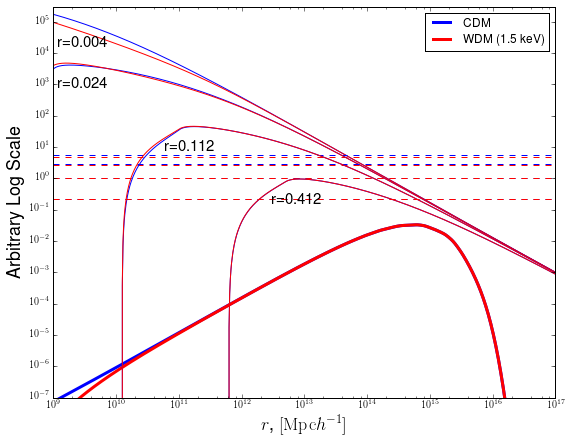

In [7]:
cdm.update(wdm_mass=100000.0,hod_params={"M_min":9.0,"M_1":10.2,"alpha":1.0})
wdm.update(wdm_mass=1.5,hod_params={"M_min":9.0,"M_1":10.2,"alpha":1.0})

plt.figure(figsize=(9,7))

cdm_ninteg = cdm.dndm*cdm.n_sat**2*cdm.n_cen * cdm.M
wdm_ninteg = wdm.dndm*wdm.n_sat**2*wdm.n_cen * wdm.M

plot(cdm.M,cdm_ninteg*1e-5,label="CDM",lw=3,color="b")
plot(cdm.M,wdm_ninteg*1e-5,label="WDM (1.5 keV)",lw=3,color="r")

for i,mvir in enumerate([5e6,1e9,1e11,5e12]):
    rvir = cdm.profile._mvir_to_rvir(mvir*cdm.M.unit)
    cdm_rinteg = cdm.profile.lam(rvir,cdm.M,norm="m")
    wdm_rinteg = wdm.profile.lam(rvir,cdm.M,norm="m")
    
    # Normalise
#    cdm_rinteg /= cdm_rinteg[-1]
#    wdm_rinteg /= wdm_rinteg[-1]
    
    plot(cdm.M,cdm_rinteg,color="b")
    plot(cdm.M,wdm_rinteg,color="r")
    annotate("r=%.3f"%rvir.value,xy=(1e10,100),xytext=(max(mvir/2,1e9)*1.2,wdm_rinteg.value.max()/6),fontsize=15)

    mask = cdm_rinteg>0
    avg_cdm = average(cdm_rinteg[mask],weights=cdm_ninteg[mask]/sum(cdm_ninteg[mask]))
    #print cdm_ninteg[mask]/sum(cdm_ninteg[mask])
    avg_wdm = average(wdm_rinteg[mask],weights=wdm_ninteg[mask]/sum(wdm_ninteg[mask]))
    axhline(avg_cdm,ls="--",color="b")
    axhline(avg_wdm,ls="--",color="r")
    print avg_wdm/avg_cdm
    #annotate("r=%.3f"%rvir.value,xy=(2e9,6e2),xytext=(1e16,3e-2),fontsize=15)


xscale('log')
yscale('log')
xlim((1e9,1e17))
ylim((1e-7,3e5))
legend(loc=0)
xlabel(r"$r$, $[{\rm Mpc}h^{-1}]$",fontsize=18)
ylabel("Arbitrary Log Scale",fontsize=18)
savefig("thorough_inv_figs/lam_m.pdf")

We see that for the $s-s$ term, due to the $N_s^2(m)$, the strength of the relative weight of $M_\star$ is greatly increased. Thus, when $M_\star\gg m_{\rm hm}$ (which is the case for any reasonable $m_x$ at $z=0$), the only difference between the CDM and WDM at $r> \sim r_{\rm vir}(M_{\rm min})$ is the mean galaxy density. This has the same quality as the $c-s$ term, but is stronger. At very small scales there is again a plateau at a scale defined by the effective concentration. In this case, there is no opportunity for an upturn. Thus we expect this to have very similar behaviour to the $c-s$ term.

## Transition Scales

### Setup

In [52]:
from halomod.wdm import ProjectedCFWDM
wdm = ProjectedCFWDM(**kwargs)
cdm = deepcopy(wdm)
cdm.update(wdm_mass=10000.0)
wdm.update(wdm_mass=2.0)

wdm.rlog=True
cdm.rlog=True
wdm.update(rp_min=1.0,rp_max=40.,rp_num=40,rnum=80,proj_limit=80.0)
cdm.update(rp_min=1.0,rp_max=40.,rp_num=40,rnum=80,proj_limit=80.0)


In determining the characteristics of the transition region, we must keep in mind that this region is the most difficult to model accurately. We will examine the relative effects of uncertain aspects of the calculation, such as scale-dependent biasing, as we perform the analysis.

The broad scale behaviour of the transition will be determined by three major factors: the behaviour of "large" scales in the 1-halo term, the behaviour of "small" scales in the 2-halo term, and the effects of halo exclusion. The 1-halo term in this region, as we have already shown, will behave exactly the same in WDM and CDM, as long as the mean density is the same. Conversely, we transition to a regime in which the behaviour is similar if the effective bias is the same. The effective bias may differ between models even when the mean densities are identical, since the bias function exhibits differences:

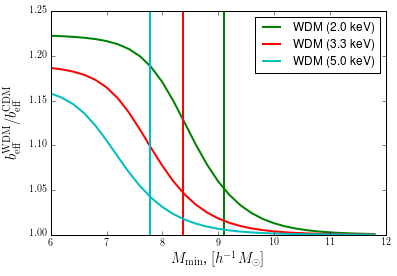

In [53]:
wdm.update(wdm_mass=2.0,hod_params={"M_min":9.0,"M_1":10.2,"alpha":1.0})
cdm.update(wdm_mass=100000.0,hod_params={"M_min":9.0,"M_1":10.2,"alpha":1.0})

mmins = np.arange(6,12,0.2)
for j,mx in enumerate([2.0,3.3,5.0]):
    wdm.update(wdm_mass=mx)
    beff_c = np.zeros_like(mmins)
    beff_w = np.zeros_like(mmins)
    for i,mmin in enumerate(mmins):
        wdm.update(hod_params={"M_min":mmin,"M_1":mmin+1.2})
        cdm.update(hod_params={"M_min":mmin,"M_1":mmin+1.2})

        beff_c[i] = cdm.bias_effective
        beff_w[i] = wdm.bias_effective
        
    plot(mmins,beff_w/beff_c,label="WDM (%s keV)"%mx,lw=2,color=["g","r","c"][j])
    axvline(log10(wdm._wdm.m_hm.value),lw=2,color=["g","r","c"][j])

legend(loc=0)
xlabel(r"$M_{\rm min}$, $[h^{-1}M_\odot]$",fontsize=15)
ylabel(r"$b_{\rm eff}^{\rm WDM}/b_{\rm eff}^{\rm CDM}$",fontsize=15)

savefig("thorough_inv_figs/beff.pdf")

This figure shows that most of the difference in the effective bias occurs when $M_{\rm min} < m_{\rm hm}$. Furthermore, having set $M_{\rm min}$ to reproduce the mean density, we may still simply alter $M_1$ or $\alpha$ (or both) to reproduce the correct $b_{\rm eff}$ at the same time. 

We define the following function to specify $M_1$ and $M_{\rm min}$ simultaneously:

In [5]:
from scipy.optimize import minimize
def get_mmin_m1(h,nbar,beff,alpha=1.0):
    h.update(ng=nbar)
    def mod(x):
        h.update(hod_params={"M_1":x[0]})
        return (h.bias_effective-beff)**2
    
    res = minimize(mod,h.hod.mmin+1.2)
    return h

Having specified the broad-scale structure, let's have a look at the transition:

In [13]:
wdm.update(hod_params={"M_min":10.0,"M_1":11.2,"alpha":1.0},wdm_mass=2.0,dlog10m=0.005)
cdm.update(hod_params={"alpha":1.0},dlog10m=0.005)

proj_rat_ng = []
proj_rat_noe = []
corr_mm = []
hod_params = []
for i,z in enumerate(np.arange(6)):
    wdm.update(z=float(z),halo_exclusion="NgMatched_")
    cdm.update(z=float(z),halo_exclusion="NgMatched_")
    cdm = get_mmin_m1(cdm,wdm.mean_gal_den.value,wdm.bias_effective)

    proj_rat_ng.append(wdm.projected_corr_gal/cdm.projected_corr_gal)
    corr_mm.append(wdm.corr_mm_base/cdm.corr_mm_base)
    hod_params.append(cdm.hod_params)

    cdm.update(halo_exclusion="NoExclusion")
    wdm.update(halo_exclusion="NoExclusion")

    proj_rat_noe.append(wdm.projected_corr_gal/cdm.projected_corr_gal)
    print "%s: "%z, cdm.hod_params, wdm.bias_effective/cdm.bias_effective

0:  {'alpha': 1.0, 'M_1': 11.199218781490186, 'M_min': 10.040210379339165} 1.00000006659
1:  {'alpha': 1.0, 'M_1': 11.196679808771727, 'M_min': 10.042325975079276} 1.00000211127
2:  {'alpha': 1.0, 'M_1': 11.190041376333207, 'M_min': 10.045734661761374} 1.00000690047
3:  {'alpha': 1.0, 'M_1': 11.177915964046143, 'M_min': 10.049849438932315} 1.00000132308
4:  {'alpha': 1.0, 'M_1': 11.161080700206421, 'M_min': 10.053969866302829} 1.00000108016
5:  {'alpha': 1.0, 'M_1': 11.139554014607674, 'M_min': 10.058034624638795} 0.999999928549


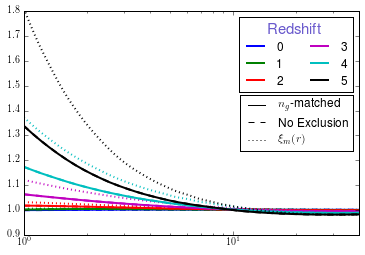

In [18]:
l1_handles = []
l1_handles.append(plot(0,0,color="k")[0])
l1_handles.append(plot(0,0,ls="--",color="k")[0])
l1_handles.append(plot(0,0,ls=":",color="k")[0])

cols = ["b",'g','r','m','c','k']
for i,z in enumerate(np.arange(6)):
    plot(cdm.rp,proj_rat_ng[i],label=str(z),lw=2,color=cols[i])
    plot(cdm.rp,proj_rat_noe[i],ls="--",lw=2,color=cols[i])
    plot(cdm.r,corr_mm[i],lw=2,color=cols[i],ls=":")

l1 = legend(l1_handles,[r"$n_g$-matched","No Exclusion",r"$\xi_m(r)$"],
            loc="center right",ncol=1)
gca().add_artist(l1)
#setp(l2.get_title(),fontsize='17',color="slateblue")

l = legend(loc=0,title="Redshift",ncol=2)
setp(l.get_title(),fontsize='15',color="slateblue")
#scale of crossover
#ratio = cdm.corr_gg_2h/cdm.corr_gg_1h
#ind = np.where(ratio>10)[0][0]
#axvline(cdm.r.value[ind],lw=2)

ylim((0.9,1.8))
xlim((1,40))
xscale('log')


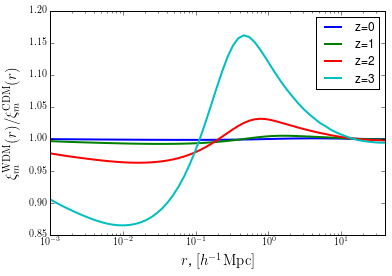

In [36]:
for i,z in enumerate(range(4)):
    cdm.update(rp_min=0.0001,z=z)
    wdm.update(rp_min=0.0001,z=z)
    plot(cdm.r,wdm.corr_mm_base/cdm.corr_mm_base,lw=2,label="z=%s"%z)
xscale('log')
xlim((1e-3,40.0))
legend(loc=0)
xlabel(r"$r$, $[h^{-1}{\rm Mpc}]$",fontsize=15)
ylabel(r"$\xi_m^{\rm WDM}(r)/\xi_m^{\rm CDM}(r)$",fontsize=15)

savefig("thorough_inv_figs/xim_small.pdf")

1.06468162835


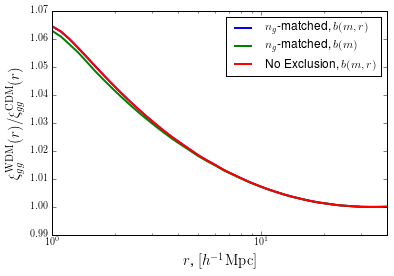

In [42]:
cdm.update(z=3,rp_min=1.0)
wdm.update(z=3,rp_min=1.0)
cdm.update(halo_exclusion="NgMatched_")
wdm.update(halo_exclusion="NgMatched_")

rat = (wdm.projected_corr_gal/cdm.projected_corr_gal)[-1]
plot(cdm.rp,(wdm.projected_corr_gal/cdm.projected_corr_gal)/rat,lw=2,label=r"$n_g$-matched, $b(m,r)$")
print ((wdm.projected_corr_gal/cdm.projected_corr_gal)/rat)[0]
cdm.update(scale_dependent_bias=None)
wdm.update(scale_dependent_bias=None)
plot(cdm.rp,(wdm.projected_corr_gal/cdm.projected_corr_gal)/rat,lw=2,label=r"$n_g$-matched, $b(m)$")

cdm.update(scale_dependent_bias="Tinker_SD05",halo_exclusion="NoExclusion")
wdm.update(scale_dependent_bias="Tinker_SD05",halo_exclusion="NoExclusion")
plot(cdm.rp,(wdm.projected_corr_gal/cdm.projected_corr_gal)/rat,lw=2,label=r"No Exclusion, $b(m,r)$")

xscale('log')
xlim((1,40))
legend(loc=0)
cdm.update(halo_exclusion="NgMatched_")
wdm.update(halo_exclusion="NgMatched_")
xlabel(r"$r$, $[h^{-1}{\rm Mpc}]$",fontsize=15)
ylabel(r"$\xi_{gg}^{\rm WDM}(r)/\xi_{gg}^{\rm CDM}(r)$",fontsize=15)

savefig("thorough_inv_figs/bmr_exclusion.pdf")

In [43]:
cdm.hod_params

{'M_1': 11.139554014607674, 'M_min': 10.568520461866184, 'alpha': 1.0}